# Deliverable D4.10
## Evaluation report on the second prototype tool for the automatic semantic description of music samples

### Tempo estimation results

In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
from collections import defaultdict
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['freesound_loops_db_4000', 'apple_loops_db', 'mixcraft_loops_db']
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)  # Load and clean datasets
methods_to_compare = ['Percival14_bpm', 'Madmom_bpm', 'rekordbox_bpm', 'ACExtractorV1', 'ACExtractorV2']
accuracy_functions = [accuracy1e, accuracy1, accuracy2]
accuracy_functions_names = ['Accuracy 1e', 'Accuracy 1', 'Accuracy 2']

DISPLAY_NAMES = {
    'ACExtractorV1': 'ACExtractorV1',
    'ACExtractorV2': 'ACExtractorV2',
    'Madmom_bpm': 'Bock15',
    'Percival14_bpm': 'Percival114',
    'rekordbox_bpm': 'RekBox',
}


Basic statistics per dataset
----------------------------

Dataset   N      T. Duration   Mean Duration   Durations range   
-----------------------------------------------------------------
FSL4      3949   8h 22m        7.63s           0.15s - 30.00s    
APPL      4611   9h 34m        7.47s           1.32s - 40.05s    
MIXL      5451   14h 11m       9.37s           0.32s - 110.77s   


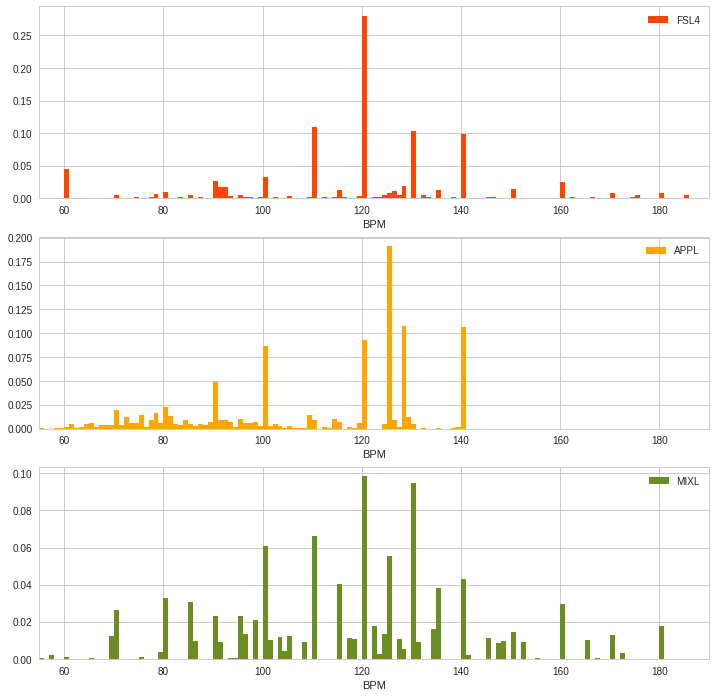

In [2]:
# Dataset stats
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    if durations:
        durations = np.array(durations)
        row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
        row.append('%.2fs' % durations.mean())
        row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    table_rows.append(row)

print(title('Basic statistics per dataset'))
print_table(table_header, table_rows, highlight_max=False)

# Tempo histograms
fig1, axs = plt.subplots(3, 1, figsize=(12, 12))
for count, dataset in enumerate(datasets):
    tempos = dataset.get_data('annotations.bpm')
    min_tempo = 30
    max_tempo = 300
    ax = axs[count]
    ax.hist(tempos, bins=max_tempo-min_tempo, range=(min_tempo,max_tempo), normed=True, label=dataset.short_name, color=COLORS[count])
    ax.set_xlabel('BPM')
    ax.set_xlim((55, 190))
    ax.legend()
plt.show()




General tempo estimation results (FSL4)
****************************************


Method          Accuracy 1e   Accuracy 1   Accuracy 2   
--------------------------------------------------------
Percival114     43.86         54.44        70.47        
ACExtractorV2   42.87         56.06        67.21        
RekBox          30.39         37.07        40.97        
ACExtractorV1   30.34         53.00        60.65        
Bock15          22.69         37.43        65.56        


General tempo estimation results (APPL)
****************************************


Method          Accuracy 1e   Accuracy 1   Accuracy 2   
--------------------------------------------------------
Percival114     55.93         69.38        79.44        
RekBox          35.24         48.02        54.13        
Bock15          34.74         46.09        71.65        
ACExtractorV2   31.71         66.71        77.32        
ACExtractorV1   31.25         66.58        78.03        


General tempo estimation resul

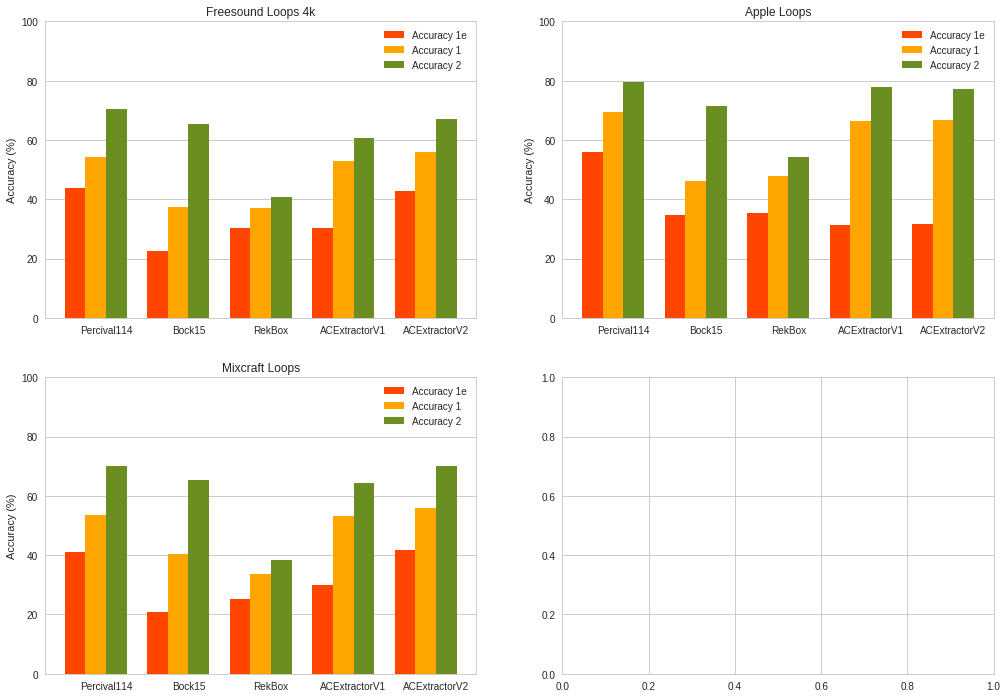

In [3]:
all_datasets_method_results = dict()
all_datasets_method_results_stats = defaultdict(list)
fig1, axs = plt.subplots(2, 2, figsize=(17, 12))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral tempo estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = defaultdict(list)
            all_datasets_method_results_stats[method] = defaultdict(list)
        try:
            table_row = [DISPLAY_NAMES.get(method, method)]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                acc_method_avg = 100 * basic_statistics(method_results)['avg']
                table_row.append(acc_method_avg)
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
                all_datasets_method_results_stats[method][accuracy_func.__name__].append(acc_method_avg)
            table_rows.append(table_row)
        except IndexError:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    ax = axs[count//2,count%2]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method) for method in methods_to_compare], rotation=0)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [4]:
print(title("General tempo estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names + ['Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results_stats.items():
    table_row = [DISPLAY_NAMES.get(method, method)]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)


General tempo estimation results (ALL DATASETS)
-----------------------------------------------

Method          Accuracy 1e   Accuracy 1   Accuracy 2   Mean accuracy   
------------------------------------------------------------------------
Percival114     46.72         59.03        73.29        59.68           
ACExtractorV2   38.77         59.57        71.62        56.66           
ACExtractorV1   30.46         57.58        67.77        51.94           
Bock15          25.93         41.45        67.43        44.94           
RekBox          30.01         39.34        44.33        37.89           


In [5]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print("")
    print(title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy_functions:
        print('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [DISPLAY_NAMES.get(method, method) for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([DISPLAY_NAMES.get(method_a, method_a)] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset FSL4
----------------------------------


Measure: accuracy1e
                Percival114   Bock15       RekBox      ACExtractorV1   ACExtractorV2   
---------------------------------------------------------------------------------------
Percival114     -             1.48e-119*   6.15e-59*   1.39e-59*       0.158           
Bock15          1.48e-119*    -            1.52e-24*   1.48e-24*       3.76e-122*      
RekBox          6.15e-59*     1.52e-24*    -           0.972           3.25e-54*       
ACExtractorV1   1.39e-59*     1.48e-24*    0.972       -               1.57e-71*       
ACExtractorV2   0.158         3.76e-122*   3.25e-54*   1.57e-71*       -               

Measure: accuracy1
                Percival114   Bock15      RekBox      ACExtractorV1   ACExtractorV2   
--------------------------------------------------------------------------------------
Percival114     -             6.29e-71*   6.1e-79*    0.0788          0.0213          
Bock15   

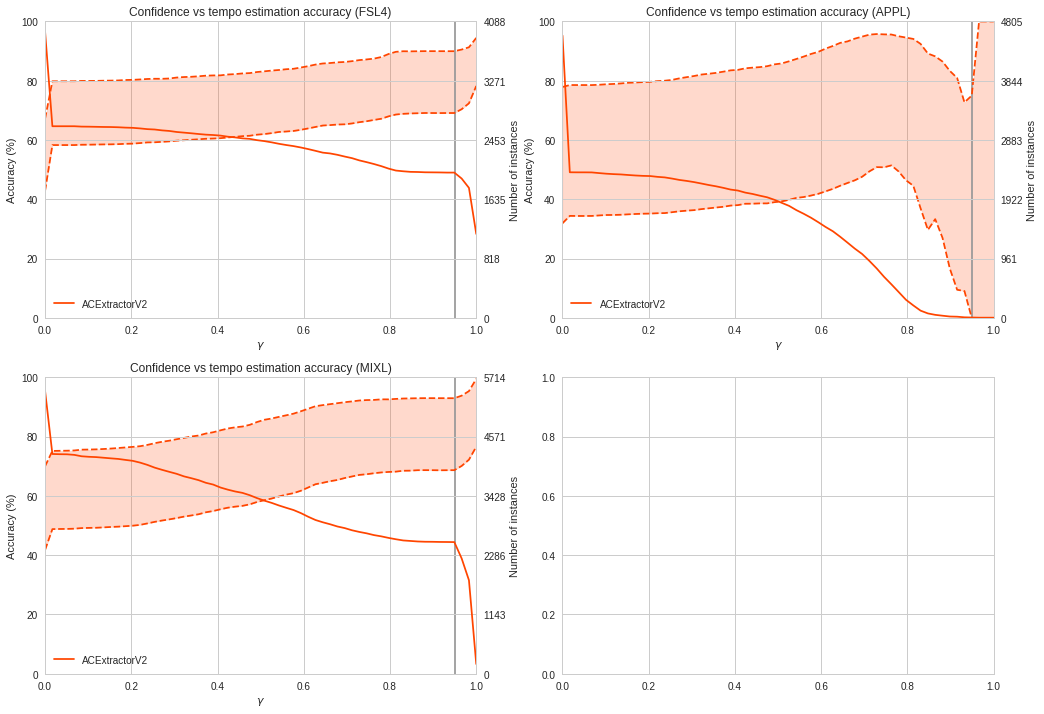

In [16]:
# Accuracy vs confidence per dataset

fig1, axs = plt.subplots(2, 2, figsize=(17, 12))
for count, dataset in enumerate(datasets):
    ax1 = axs[count//2,count%2]
    ax2 = ax1.twinx()
    for count, method in enumerate(['ACExtractorV2']):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'bpm_confidence'), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    ax1.set_xlim(0.0, 1.0)
    ax1.set_title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)


In [10]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in ['ACExtractorV2']:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'bpm_confidence'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        except IndexError:
            print('Unable to compute results for method %s and dataset %s' % (method, dataset.short_name))
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)

print_table(table_header, table_rows)

Method          FSL4                      APPL                    MIXL                      
--------------------------------------------------------------------------------------------
ACExtractorV2   A=69.13 - 89.98%, N=51%   A=0.00 - 75.00%, N=0%   A=68.68 - 92.95%, N=47%   
